In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import cm
from matplotlib import colors

First, let's input the data and setup our x (time) and y (species flow rates) arrays.

In [3]:
inputexcel = '190129 Space-time yields experimental data (5-133.1).xlsx' #ENTER EXCEL NAME HERE
inputsheet = 'Experimental Space-time yields' #ENTER SHEET NAME HERE

skipbeginpoints = 5; #MAX number of points to possibly skip at beginning
skipendpoints = 0; #number of points to skip at end 

ws = pd.read_excel(inputexcel, sheet_name=inputsheet)
headerstr = list(ws.head(0))
data = np.array(ws)
speciestr = list(data[0])
data = np.delete(data,0,0)
data = np.delete(data,0,0)

data = data.T #Now in format of data = [Ethane data[], Propene data[], ...]

timenp = data[0:2] #x np array
newtime = np.linspace(0,timenp[1,-1], num=len(timenp[1])) #for printing initial time points - used in graphing
speciesnp = data[2::] #y np array

#reformat column header list
speciestr = [x for x in speciestr if str(x) != 'nan']
speciestr.insert(0,str(headerstr[2])) #species headers 
timestr = headerstr[0:2] #time headers
stystr = headerstr[3] #STY header


We'll first try to fit using the hyperbolic, mulitsite deactivation curve. If this doesn't appear to be working (R^2 < 0.97), then we'll fit it to the exponential decay, single site deactivate curve.

In [4]:
def funcapp(x, y0, k, n): #apparent catalytic deactivation
    return (y0/((1+(n-1)*k*(y0**(n-1))*x)**(1/(n-1))))

def expdec(x, y0, k): #exponential decay
    return (y0*np.exp(-k*x))

In [5]:
#the maximum STY for each species
maxvales = np.amax(speciesnp, axis=1)

#initiate arrays and lists to populate
popt = np.empty((0,3), float) #fitted parameters
perr = np.empty((0,3), float) #standard deviate/error of parameters
chisq = [] #X^2 values
pval = [] #p values
rsq = [] #R^2 values
exceptions = [] #list of exceptions from hyperbolic, must use exp decay

for i, sp in enumerate(speciesnp): #loop through each species
    for j, point in enumerate(sp):
        if point < 0:
            sp[j] = 0
    if maxvales[i] < 1.0e-4: #if largest value is less than 1e-4, rescale with initial guess to be 1
        scale = maxvales[i]
        maxvales[i] = 1
    else:
        scale = 1

    r_squared = 0.0
    n = 0

    while r_squared < 0.97 and n <= skipbeginpoints: #Try to fit the hyperbolic apparent function. Remove an additional initial point each run to gain a better fit.
        timecrop = np.array(timenp)[::,n:] #crop time points to take into account skipped points
        spcrop = np.array(speciesnp)[::,n:] #crop STY points to take into account skipped points

        if skipendpoints != 0:
            timecrop = np.array(timecrop)[::,:-skipendpoints]
            spcrop = np.array(spcrop)[::,:-skipendpoints]/scale
        else:
            spcrop = spcrop/scale
        
        times = np.array(timecrop[1], dtype=float) #make curve_fit inputs explicit 1D np float arrays to reduce errors
        rates = np.array(spcrop[i], dtype=float)
        
        try:
            popti, pcovi = curve_fit(funcapp, times, rates, p0=(float(rates[0]), 0.0001, 2), bounds=((0,0, 1),(rates[0]*10+0.001,np.inf,5))) #once cropped, use first point as intial point
            perri = np.sqrt(np.diag(pcovi))

            residuals = spcrop[i]-funcapp(times, *popti) #residuals = ydata - f(xdata, popt)
            ss_res = np.sum(residuals**2)                # SSres = SUMi (yi-fi)^2 = SUMi (residualsi)^2
            ss_tot = np.sum((spcrop[i]-np.mean(spcrop[i]))**2) #SStot = SUMi (yi - ybar)^2
            r_squared = 1 - (ss_res / ss_tot)            #R^2 = 1-SSres/SStot
            n += 1
        except RuntimeError: #If shape is bad, will not converge and throw an error. If this happens, we try to remove another point to reduce initial artifacts
            n += 1
    
    n = 0
    if r_squared < 0.97: #If fit is still bad, we index to exceptions list for later
        exceptions.append(i)
        while r_squared < 0.97 and n <= skipbeginpoints: #Try to fit the exponential decay function. Remove an additional initial point each run to gain a better fit.
            timecrop = np.array(timenp)[::,n:] 
            spcrop = np.array(speciesnp)[::,n:] 

            if skipendpoints != 0:
                timecrop = np.array(timecrop)[::,:-skipendpoints]
                spcrop = np.array(spcrop)[::,:-skipendpoints]/scale
            else:
                spcrop = spcrop/scale
            
            times = np.array(timecrop[1], dtype=float) 
            rates = np.array(spcrop[i], dtype=float)

            popti, pcovi = curve_fit(expdec, times, rates, p0=(float(rates[0]), 0.0001), bounds=((0,0),(rates[0]*10+0.001,np.inf))) 
            perri = np.sqrt(np.diag(pcovi))

            residuals = spcrop[i]-expdec(times, *popti)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((spcrop[i]-np.mean(spcrop[i]))**2)
            r_squared = 1 - (ss_res / ss_tot)
            n += 1
    
    if i in exceptions: #if exception, use exp decay
        popts = [popti[0]*scale,popti[1]] #rescale fitted parameters to original scale
        chisqa, pvala = stats.chisquare(expdec(times, *popts), spcrop[i], ddof=(spcrop.shape[1]-2)) #calculate X^2 and p value, ddof = # of points fitted - # of parameters fit (y0, k)
        perrs = [perri[0]*scale,perri[1],0.0] #to retain the same dimensions of popt for hyperbolic and exp decay, we add a 0 for a 1x3 popti and perri always
        popts.append(0.0)

    else: #otherwise, use hyperbolic deactivation
        popts = [popti[0]*scale,popti[1]*scale**(1-popti[2]),popti[2]] #rescale fitted parameters to original scale, 
        perrs = [perri[0]*scale,perri[1]*scale**(1-popti[2]),perri[2]] ##rescale errors to original scale
        chisqa, pvala = stats.chisquare(funcapp(times, *popts), spcrop[i], ddof=(spcrop.shape[1]-3)) #calculate X^2 and p value, # of points fitted - # of parameters fit (y0, kd, n)
        
    
    popt = np.vstack((popt, popts)) #add to our growing fitten parameter list
    perr = np.vstack((perr, perrs))
    rsq.append(r_squared)
    chisq.append(chisqa) #add to our growing X and p value list
    pval.append(pvala)

In [6]:
#Print fitted parameters ----

print('\033[1m'+'Apparent Model Fit'+'\033[0m')

rsqnp = np.array([rsq]) #turn list into array of (11,1) to play nice with the other arrays
chisqnp = np.array([chisq])
pvalnp = np.array([pval])

prspeciestr = speciestr.copy()
for i, sp in enumerate(prspeciestr): #mark our species exceptions with a *
    if i in exceptions:
        prspeciestr[i] = sp + "*"

#combine all output data - parameters
prpopt = np.append(popt, perr, 1)
prpopt = np.append(prpopt, rsqnp.T, 1)
prpopt = np.append(prpopt, chisqnp.T, 1)
prpopt = np.append(prpopt, pvalnp.T, 1)

prpopt = np.vstack((['y0', 'kd', 'n','y0 std dev', 'kd std dev', 'n std dev', 'r^2 value', 'X^2$ value','p value'], prpopt))

#create data frame (to export to excel)
prspeciestrparam = prspeciestr.copy()
prspeciestrparam.insert(0, 'Parameters')

dfpopt = pd.DataFrame(prpopt.T, columns = [prspeciestrparam])
display(dfpopt)


Apparent Model Fit


,Parameters,Conversion\n (R-based) %,Ethane,Propene,isobutane,n-butane,C₄ alkanes,trans-2-butene,1-butene,isobutene,cis-2-butene,C₄ alkenes,C₅ alkanes,C₅ alkenes,C₆ alkanes,C₆ alkenes*,C₇ alkanes*
0,y0,26.629299663198545,1.73440546476208e-08,4.060256916233695e-09,7.3668120374053525e-09,3.880584287736865e-10,8.024731803734897e-09,3.160071141199653e-08,6.6266321167141005e-09,1.0993094863518175e-08,1.755549899412962e-08,6.470880429646209e-08,4.181224265217989e-09,7.273198362927372e-09,3.1919510703175326e-09,2.6014064830787952e-09,3.2434970566845682e-09
1,kd,6.833071672606303e-09,7.242717460431592,15169.305266339821,0.03279207049512064,37.667184486347445,0.14795839643029968,201793.8038883723,772645.715278337,12.30132493549498,850795.1384411482,27524.584409951203,0.016842442105227597,6.886504883191711,0.096335475836255,9.141258856259322e-06,6.225380930687389e-05
2,n,4.03720704203217,1.649047894281711,1.976768196075643,1.2839331811900785,1.61008152883208,1.3639615319695555,2.3156243608722367,2.2838496607184795,1.657904821140736,2.3540279730459366,2.2462178073368473,1.250018137733426,1.6334371932991176,1.3677913509615607,0.0,0.0
3,y0 std dev,0.5814258905217249,3.547029614809221e-10,1.6130428208341988e-10,2.8571284205647794e-10,1.4164200410261976e-11,3.466039182621067e-10,4.5709098144382736e-10,9.44600054327508e-11,1.7026798181350133e-10,2.559244126328363e-10,6.673176237415369e-10,1.6909811431974222e-10,1.400371126850876e-10,1.3429049628672684e-10,4.825535944887457e-11,3.838470013392879e-10
4,kd std dev,7.096473808368483e-09,0.3010206756313796,1121.1473361341803,0.001292638917730479,2.7483613812498904,0.006188559951214649,11178.815756847525,44799.21564696017,0.29478948791582593,48506.56733944324,958.3012546303519,0.0007832173949308438,0.24644175303521132,0.008313741477205264,3.711182630585447e-07,5.85671796467181e-06
5,n std dev,0.1812023803197012,0.049326944193477516,0.0847504987616211,0.037398765950684906,0.08574615327016402,0.03973669866113957,0.08914406966549343,0.09607249398806299,0.027672073327887757,0.0930335895426704,0.05648659639877817,0.04600649312273236,0.04510410012913958,0.09229388955012459,0.0,0.0
6,r^2 value,0.9838734345646519,0.9930730956112116,0.9818521882298872,0.9960787546360909,0.9784669681113732,0.9953090558527732,0.9920819487638404,0.9915029049150205,0.9977629120995213,0.9917452135598637,0.9963558506674925,0.9940747334509427,0.9948549164662621,0.9726787948152972,0.9543457208597034,0.8980984392928995
7,X^2$ value,0.8075660372940545,13.110731621521813,12.551945445552265,5.290973939335153,12.768676475831143,5.753231150131851,21.033755550368234,21.694990530137392,12.395341787025822,21.27094777600664,20.907644595455775,5.806850664602824,15.167503012224424,10.144777813072702,21.228073737293137,7.0629593072119645
8,p value,0.6677890033114486,0.0014224624197575132,0.001880960510488181,0.07097078470384931,0.0016877850382675755,0.056325068581243656,2.7075595382901957e-05,1.9453272209287776e-05,0.002034162905195649,2.404763536174621e-05,2.8837835576341732e-05,0.05483506966618734,0.0005086494377448593,0.006267429938487733,4.077481644416577e-06,0.007869389937878302


In [11]:
#combine all output data - STY
prtime = np.insert(timenp,0,0,1)
data = np.vstack((prtime[0], prtime[1]))

for i, sp in enumerate(speciesnp):
    if i in exceptions:
        run = expdec(np.array(prtime[1], dtype = float),popt[i,0],popt[i,1])
    else:
        run = funcapp(np.array(prtime[1]), *popt[i])
    data = np.vstack((data, run)) 
    
prdata = timestr.copy() + prspeciestr
dfdata = pd.DataFrame(data.T, columns = prdata) #Modeled dataframe
display(dfdata)

prdata2 = timestr.copy() + speciestr
dataexp = np.vstack((timenp,speciesnp))
dfexpdata = pd.DataFrame(dataexp.T, columns = prdata2) #Experimental dataframe

,Time on stream [h],Time on stream [sec],Conversion (R-based) %,Ethane,Propene,isobutane,n-butane,C₄ alkanes,trans-2-butene,1-butene,isobutene,cis-2-butene,C₄ alkenes,C₅ alkanes,C₅ alkenes,C₆ alkanes,C₆ alkenes*,C₇ alkanes*
0,0,0,26.6293,1.73441e-08,4.06026e-09,7.36681e-09,3.88058e-10,8.02473e-09,3.16007e-08,6.62663e-09,1.09931e-08,1.75555e-08,6.47088e-08,4.18122e-09,7.2732e-09,3.19195e-09,2.60141e-09,3.2435e-09
1,0.0619444,223,25.8163,1.709e-08,3.97471e-09,7.10842e-09,3.8222e-10,7.73269e-09,3.14092e-08,6.59077e-09,1.08203e-08,1.74512e-08,6.42757e-08,4.05733e-09,7.19573e-09,3.14106e-09,2.59611e-09,3.19878e-09
2,0.535833,1929,21.7307,1.53337e-08,3.42204e-09,5.47115e-09,3.4187e-10,5.91377e-09,3.0028e-08,6.33038e-09,9.63502e-09,1.66991e-08,6.11655e-08,3.24662e-09,6.6451e-09,2.78612e-09,2.55594e-09,2.87647e-09
3,1.01222,3644,19.4083,1.38493e-08,3.00116e-09,4.28267e-09,3.07799e-10,4.62622e-09,2.87735e-08,6.09114e-09,8.64573e-09,1.60156e-08,5.83601e-08,2.6258e-09,6.15771e-09,2.48237e-09,2.51618e-09,2.58519e-09
4,1.48639,5351,17.851,1.25932e-08,2.673e-09,3.40971e-09,2.79005e-10,3.69641e-09,2.76391e-08,5.87259e-09,7.81772e-09,1.53974e-08,5.58394e-08,2.14851e-09,5.72802e-09,2.22329e-09,2.47722e-09,2.32456e-09
5,1.96028,7057,16.7008,1.15151e-08,2.40907e-09,2.75291e-09,2.54327e-10,3.00431e-09,2.66038e-08,5.67127e-09,7.11376e-09,1.48328e-08,5.35521e-08,1.77509e-09,5.34543e-09,1.99993e-09,2.43889e-09,2.09034e-09
6,3.49306,12575,14.329,8.89368e-09,1.8239e-09,1.48896e-09,1.94522e-10,1.68196e-09,2.37898e-08,5.11523e-09,5.42839e-09,1.32968e-08,4.73993e-08,1.01225e-09,4.35518e-09,1.45708e-09,2.31892e-09,1.48262e-09
7,3.9675,14283,13.824,8.2766e-09,1.69589e-09,1.25572e-09,1.805e-10,1.43717e-09,2.30517e-08,4.96725e-09,5.03715e-09,1.28935e-08,4.5801e-08,8.63451e-10,4.1082e-09,1.33035e-09,2.28299e-09,1.33307e-09
8,4.44194,15991,13.3839,7.72707e-09,1.5845e-09,1.06737e-09,1.68037e-10,1.23852e-09,2.23645e-08,4.8287e-09,4.69054e-09,1.25178e-08,4.43189e-08,7.41013e-10,3.88331e-09,1.21823e-09,2.24763e-09,1.1986e-09
9,4.91389,17690,12.9973,7.23768e-09,1.48718e-09,9.14531e-10,1.56959e-10,1.07629e-09,2.17263e-08,4.69933e-09,4.3833e-09,1.21688e-08,4.29474e-08,6.40017e-10,3.67888e-09,1.11914e-09,2.21299e-09,1.0783e-09


In [12]:
#Export and plot in EXCEL ---
rgbacolors=cm.rainbow(np.linspace(0,1,speciesnp.shape[0]))
hexcolors = [] #split the rainbow into the number of species we have so we can make pretty plots
for c, color in enumerate(rgbacolors):
    run = colors.to_hex(color)
    hexcolors.append(run) #but excel only likes hex so fine let's convert everything

outputexcel = inputexcel.replace('.xlsx', ' - Modeled.xlsx') #name of new excel will just add "Modeled" to the old name
outputsheet = 'Yields Modeled' #name of new sheet

writer = pd.ExcelWriter(outputexcel, engine = 'xlsxwriter', options={'strings_to_numbers': True})

#write dataframes to excel document
dfdata.to_excel(writer, sheet_name = outputsheet, index=False, startrow = 1)
dfpopt.to_excel(writer, sheet_name = outputsheet, index=False, startcol=len(prdata)+1, startrow = 1)
dfexpdata.to_excel(writer, sheet_name = outputsheet, index=False, startrow = timenp.shape[1]+5)

workbook  = writer.book
worksheet = writer.sheets[outputsheet]

#excel formatting
worksheet.set_column('A:C', 13.5)
worksheet.set_column(len(prdata)+1, len(prdata)+2, 13.5)
format1 = workbook.add_format({'text_wrap': True, 'bold': True, 'align':'center'})
format2 = workbook.add_format({'text_wrap': True, 'bold': True, 'align':'center', 'bottom':True})

#format headers
for col, header in enumerate(prdata):
    worksheet.write(1, col , header , format1)
    
for col, header in enumerate(prdata):
    worksheet.write(timenp.shape[1]+5, col , header , format1)
    
for col, header in enumerate(prspeciestrparam):
    worksheet.write(1, col+len(prdata)+1, header , format1)
    
worksheet.write(1, len(prspeciestrparam)+len(prdata)+1, '' , format1)
worksheet.write(0, 0, 'Modeled Data' , format2)
worksheet.write(timenp.shape[1]+4, 0, 'Experimental Data' , format2)

#create chart
#categorties: x data | values: data
chart = workbook.add_chart({'type': 'scatter',
                             'subtype': 'smooth_with_markers'})

for i, species in enumerate(speciestr):
    if i == 0: #put conversion on the secondary axis, all other STY go to the primary axis
        y2 = 1
    else:
        y2 = 0
    chart.add_series({ #Modeled lines
        'name':       'Modeled {}'.format(species),
        'categories': [outputsheet, 2, 1, timenp.shape[1]+2, 1], #[sheetname, first_row, first_col, last_row, last_col]
        'values':     [outputsheet, 2, i+2, timenp.shape[1]+2, i+2],
        'marker':     {'type': 'none'},
        'line':       {'width': 1.5,
                       'color': '{}'.format(hexcolors[i])},
        'y2_axis': y2
        })
    
for i, species in enumerate(speciestr):
    if i == 0:
        y2 = 1
    else:
        y2 = 0
    chart.add_series({ #Experimental points
        'name':       '{}'.format(species),
        'categories': [outputsheet, timenp.shape[1]+6, 1, timenp.shape[1]*2+5, 1],
        'values':     [outputsheet, timenp.shape[1]+6, i+2, timenp.shape[1]*2+5, i+2],
        'marker':     {'type': 'circle', 
                        'size' : 4,
                         'border': {'color': 'black', 'width': 0.5},
                        'fill':   {'color': '{}'.format(hexcolors[i])}
                          },
        'line':   {'none':True},
        'y2_axis': y2
        })

chart.set_x_axis({'name': timestr[1],
                  'name_font': {'size': 10,
                                'bold': False},
                 'major_gridlines': {'visible': False},
                  'min': 0, 
                  'max': timenp[1,-1]
                 })
chart.set_y_axis({'name': stystr,
                  'name_font': {'size': 10,
                                'bold':False},
                 'major_gridlines': {'visible': False},
                 })
chart.set_y2_axis({'name': speciestr[0],
                  'name_font': {'size': 10,
                                'bold': False,
                               'color': '{}'.format(hexcolors[0])},
                 'major_gridlines': {'visible': False},
                 })

notlist = list(range(0, len(speciestr)-1))
notlist.append(len(speciestr)*2-2)
chart.set_legend({'font': {'size': 9}, 'delete_series': notlist})
chart.set_plotarea({'border': {'color': '#969696', 'width': 1, 'dash_type': 'solid'}})

worksheet.insert_chart(14, len(prdata)+1, chart, {'x_scale': 1.6, 'y_scale': 1.6})

worksheet.merge_range(0, 3, 0, int(len(speciestr)+1), stystr , format2)
worksheet.merge_range(timenp.shape[1]+4, 3, timenp.shape[1]+4, int(len(speciestr)+1), stystr , format2)

writer.save()
writer.close()

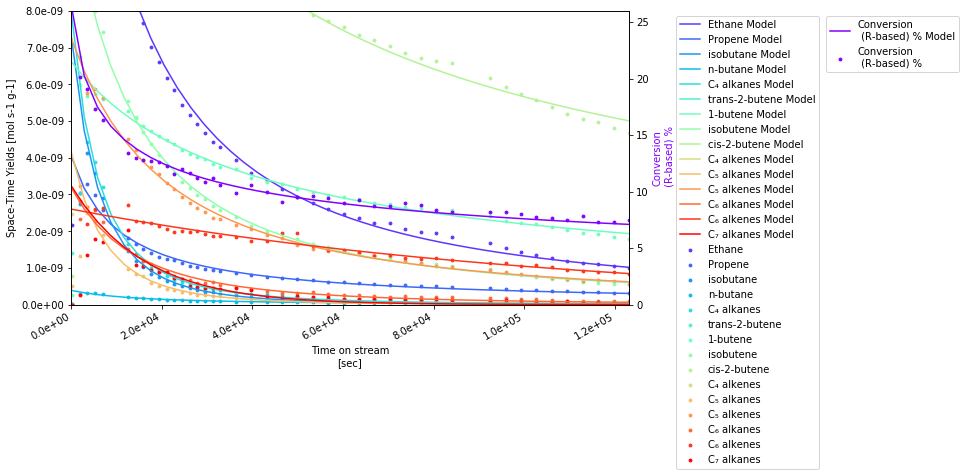

In [13]:
#Plot in python ---------
color=cm.rainbow(np.linspace(0,1,speciesnp.shape[0]))
fig, ax1 = plt.subplots(1, figsize=(10,6))
axes = plt.gca()   
axes.set_ylim(bottom=0.) #set rate axis > 0
ax1.set_xlabel(timestr[1])
ax1.set_xlim(0,timenp[1,-1])
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e')) #show axis numbers in scientific notation
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.set_ylabel(stystr)
ax1.set_ylim(0,8e-9) #CHANGE THIS TO VIEW WHAT YOU WANT

ax2 = ax1.twinx() #plot conversion on a secondary axis
ax2.set_ylabel(speciestr[0], color = color[0])
ax2.set_ylim(0,26)

for i, sp in enumerate(speciesnp):
    if i == 0:
        ax2.scatter(timenp[1], speciesnp[i],  color=color[i], s=8, label=speciestr[i]) #plot exp data   
        if i in exceptions:
            ax2.plot(newtime,expdec(np.array(newtime), popt[i,0], popt[i,1]), color=color[i], label=speciestr[i]+' Model')
        else:
            ax2.plot(newtime,funcapp(np.array(newtime), *popt[i]), color=color[i], label=speciestr[i]+' Model') #plot fitted line 
    else:
        ax1.scatter(timenp[1], speciesnp[i],  color=color[i], s=8, label=speciestr[i]) #plot exp data  
        if i in exceptions:
            ax1.plot(newtime,expdec(np.array(newtime), popt[i,0], popt[i,1]), color=color[i], label=speciestr[i]+' Model') #plot fitted line
        else:
            ax1.plot(newtime,funcapp(np.array(newtime), *popt[i]), color=color[i], label=speciestr[i]+' Model')

ax1.legend(bbox_to_anchor=(1.35,1), loc='upper right', ncol=1)
ax2.legend(bbox_to_anchor=(1.6,1), loc='upper right', ncol=1)

fig.autofmt_xdate()
plt.show()